In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
outer_dir = "training_runs/original_grid_settings/"

# Feature Importance Analysis

In [3]:
def k_fold_feature_importance_metrics(cph_file_name, rsf_file_name, sorted_feature_names): 
    regression_coefficients = []
    p_values = []
    rsf_weights = []
    for i in range(5):
        ### CPH feature importance
        fold_cph_file = outer_dir + "split" + str(i) + "/results/" + cph_file_name
        cph_table = pd.read_html(fold_cph_file)
        assert len(cph_table) == 1
        fold_cph_df = cph_table[0]
        fold_cph_df.rename(columns={"Unnamed: 0":"Feature"}, inplace=True)

        # Check that the feature order is the same for all folds
        fold_cph_df.sort_values(by=["Feature"], inplace = True)
        assert list(fold_cph_df["Feature"]) == sorted_feature_names

        regression_coefficients.append(fold_cph_df["coef"].to_numpy())
        p_values.append(fold_cph_df["p"].to_numpy())

        ### RSF feature importance
        fold_rsf_file = outer_dir + "split" + str(i) + "/results/" + rsf_file_name
        rsf_table = pd.read_html(fold_rsf_file)
        assert len(rsf_table) == 1
        fold_rsf_df = rsf_table[0]

        # Check that the feature order is the same for all folds
        fold_rsf_df.sort_values(by=["Feature"], inplace = True)
        assert list(fold_rsf_df["Feature"]) == sorted_feature_names

        fold_rsf_df[["Weight Avg", "Weight Std"]] = fold_rsf_df["Weight"].str.split("±", expand=True).astype("float")
        rsf_weights.append(fold_rsf_df["Weight Avg"])

    regression_coefficients = np.stack(regression_coefficients, axis=0)
    avg_coef = np.mean(regression_coefficients, axis=0)
    std_coef = np.std(regression_coefficients, axis=0)
    str_regression_coefficients = ["{:.3f} ± {:.3f}".format(mean, std) for (mean, std) in zip(avg_coef, std_coef)]

    p_values = np.stack(p_values, axis=0)
    avg_p = np.mean(p_values, axis = 0)
    std_p = np.std(p_values, axis = 0)
    str_p_values = ["{:.3f} ± {:.3f}".format(mean, std) for (mean, std) in zip(avg_p, std_p)]

    rsf_weights = np.stack(rsf_weights, axis=0)
    rsf_weight_avg_across_folds = np.mean(rsf_weights, axis=0)
    rsf_weight_std_across_folds = np.std(rsf_weights, axis=0)
    str_rsf_weights = ["{:.3f} ± {:.3f}".format(mean, std) for (mean, std) in zip(rsf_weight_avg_across_folds, rsf_weight_std_across_folds)]

    k_fold_df = pd.DataFrame(data={"Feature": sorted_feature_names, "CPH coefficient": str_regression_coefficients, "CPH p-value": str_p_values, "RSF Importance Weight": str_rsf_weights})
    
    return k_fold_df, avg_coef, std_coef, avg_p, std_p, rsf_weight_avg_across_folds, rsf_weight_std_across_folds

## Clinical

In [4]:
clin_feature_names = [
        'Age',
        'BMI',
        'Pack-year',
        'Smoking-start-age',
        'Cigarettes-per-day',
        'Number-of-smoking-years',
        'High-school-graduate',
        'Post-HS-training',
        'Associate-degree',
        'Bachelors-degree',
        'Graduate-school',
        'Female',
        'Non-white',
        'Smoking-at-the-start-of-trial',
        'Lived-with-smoker',
        'Worked-with-smoker',
        'Cancer-prior-to-trial',
        'Family-member-had-cancer']

clin_feature_names.sort()

In [5]:
cph_file_name = "cph_clinical_all.html"
rsf_file_name = "rsf_clinical_all.html"

clinical_df, avg_coef, std_coef, avg_p, std_p, avg_rsf_weight, std_rsf_weight = k_fold_feature_importance_metrics(cph_file_name, rsf_file_name, clin_feature_names)
display(clinical_df)

,Feature,CPH coefficient,CPH p-value,RSF Importance Weight
0,Age,-0.008 ± 0.017,0.955 ± 0.088,0.057 ± 0.029
1,Associate-degree,0.022 ± 0.045,0.947 ± 0.105,0.005 ± 0.004
2,BMI,0.016 ± 0.033,0.904 ± 0.192,0.095 ± 0.017
3,Bachelors-degree,-0.026 ± 0.048,0.950 ± 0.091,0.005 ± 0.001
4,Cancer-prior-to-trial,0.144 ± 0.166,0.752 ± 0.283,0.003 ± 0.004
5,Cigarettes-per-day,0.008 ± 0.015,0.966 ± 0.068,0.023 ± 0.014
6,Family-member-had-cancer,0.059 ± 0.117,0.861 ± 0.278,0.015 ± 0.012
7,Female,-0.124 ± 0.093,0.663 ± 0.216,0.021 ± 0.012
8,Graduate-school,-0.024 ± 0.048,0.957 ± 0.086,0.005 ± 0.004
9,High-school-graduate,0.049 ± 0.040,0.875 ± 0.103,0.014 ± 0.011


In [6]:
def plot_metrics(mean_array, std_array, feature_names, ylabel, title, ax):
    sorted_idx = np.argsort(mean_array)

    feature_index = np.arange(len(feature_names))
    ax.bar(feature_index, mean_array[sorted_idx], yerr=std_array[sorted_idx], align='center', capsize=5)
    ax.set_xticks(feature_index)
    ax.set_xticklabels([feature_names[i] for i in sorted_idx], rotation=90)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(axis='y')
#     ax.rc('font', {'name': 'times'})

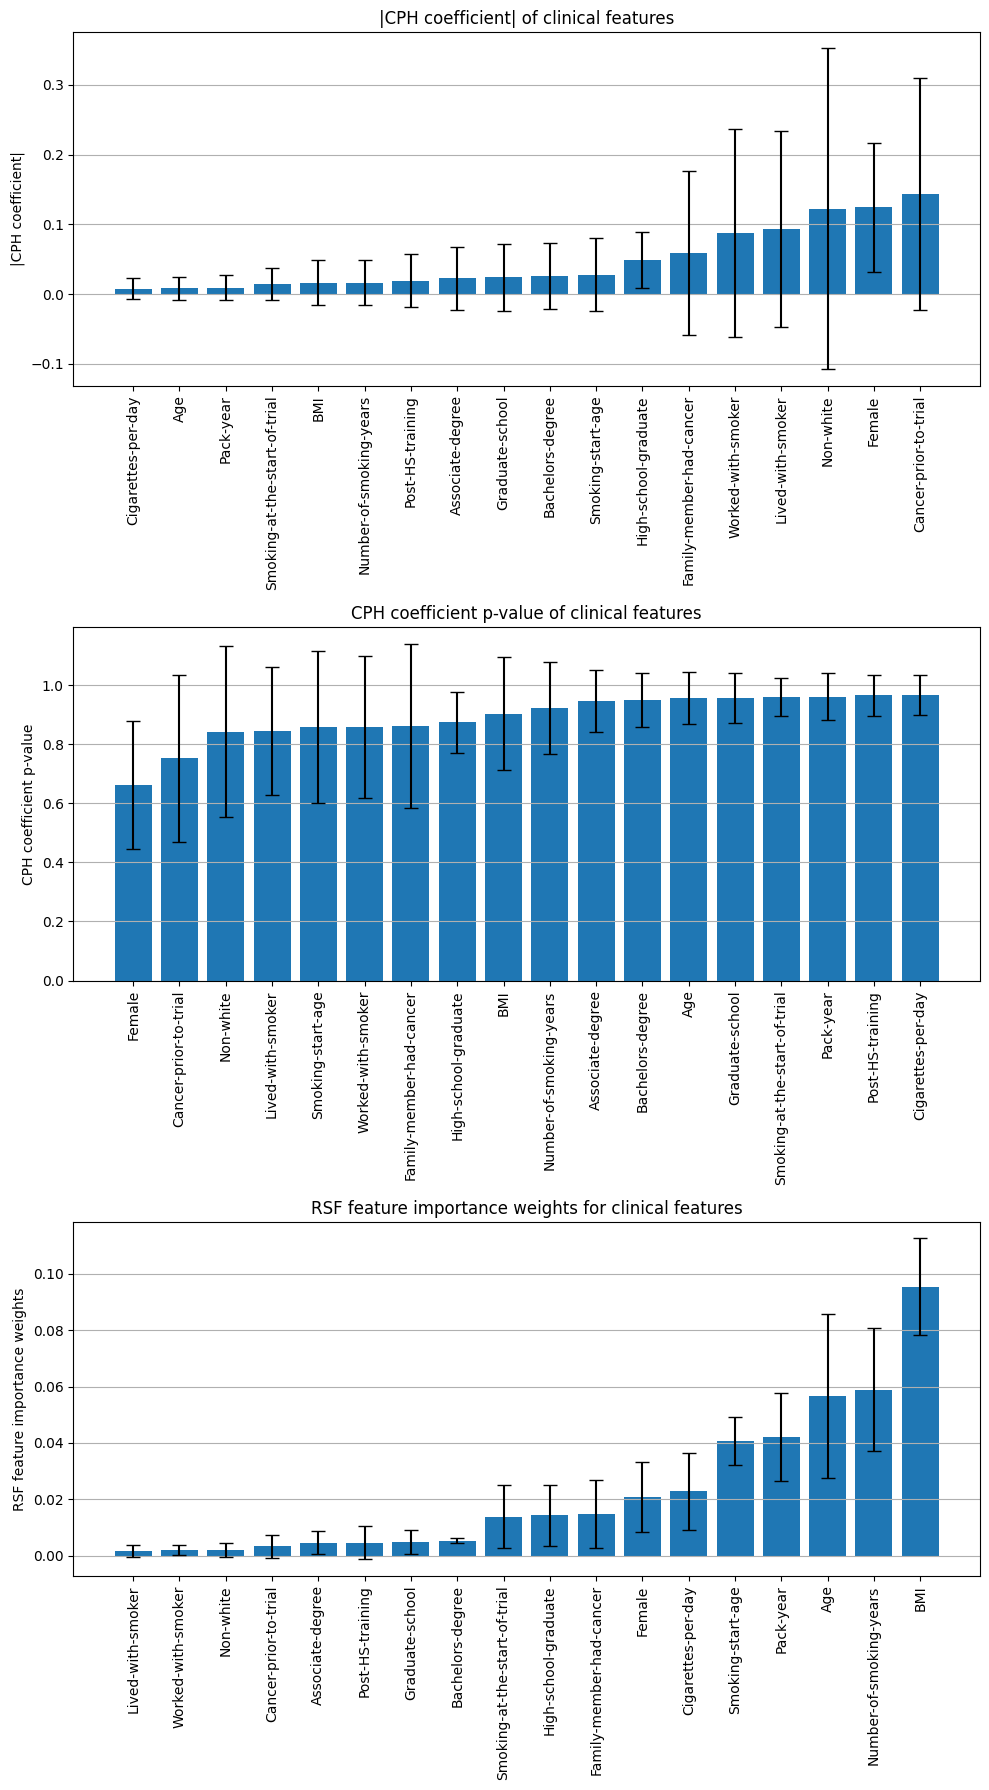

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(10,18))

plot_metrics(np.absolute(avg_coef), std_coef, clin_feature_names, '|CPH coefficient|','|CPH coefficient| of clinical features', axes[0])
plot_metrics(avg_p, std_p, clin_feature_names, 'CPH coefficient p-value','CPH coefficient p-value of clinical features', axes[1])
plot_metrics(avg_rsf_weight, std_rsf_weight, clin_feature_names, 'RSF feature importance weights','RSF feature importance weights for clinical features', axes[2])

fig.tight_layout()

## Radiomics 1

In [8]:
radiomics1_feature_names = ['original_shape_Elongation', 'original_shape_Flatness', 'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength', 'original_shape_Maximum2DDiameterColumn', 'original_shape_Maximum2DDiameterRow', 'original_shape_Maximum2DDiameterSlice', 'original_shape_Maximum3DDiameter', 'original_shape_MinorAxisLength', 'original_shape_Sphericity', 'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio', 'original_shape_VoxelVolume']
radiomics1_feature_names.sort()

In [9]:
cph_file_name = "cph_radiomics1_all.html"
rsf_file_name = "rsf_radiomics1_all.html"

radiomics1_df, rad1_avg_coef, rad1_std_coef, rad1_avg_p, rad1_std_p, rad1_avg_rsf_weight, rad1_std_rsf_weight = k_fold_feature_importance_metrics(cph_file_name, rsf_file_name, radiomics1_feature_names)
display(radiomics1_df)

,Feature,CPH coefficient,CPH p-value,RSF Importance Weight
0,original_shape_Elongation,-0.186 ± 0.107,0.455 ± 0.164,0.028 ± 0.016
1,original_shape_Flatness,0.064 ± 0.065,0.839 ± 0.150,0.024 ± 0.015
2,original_shape_LeastAxisLength,-0.008 ± 0.087,0.936 ± 0.090,0.029 ± 0.028
3,original_shape_MajorAxisLength,0.023 ± 0.132,0.799 ± 0.158,0.037 ± 0.017
4,original_shape_Maximum2DDiameterColumn,0.354 ± 0.181,0.346 ± 0.132,0.018 ± 0.015
5,original_shape_Maximum2DDiameterRow,-0.147 ± 0.448,0.718 ± 0.280,0.022 ± 0.019
6,original_shape_Maximum2DDiameterSlice,-0.361 ± 0.631,0.722 ± 0.366,0.019 ± 0.016
7,original_shape_Maximum3DDiameter,0.396 ± 0.446,0.580 ± 0.159,0.026 ± 0.016
8,original_shape_MinorAxisLength,0.099 ± 0.228,0.918 ± 0.129,0.019 ± 0.011
9,original_shape_Sphericity,0.189 ± 0.099,0.345 ± 0.145,0.037 ± 0.015


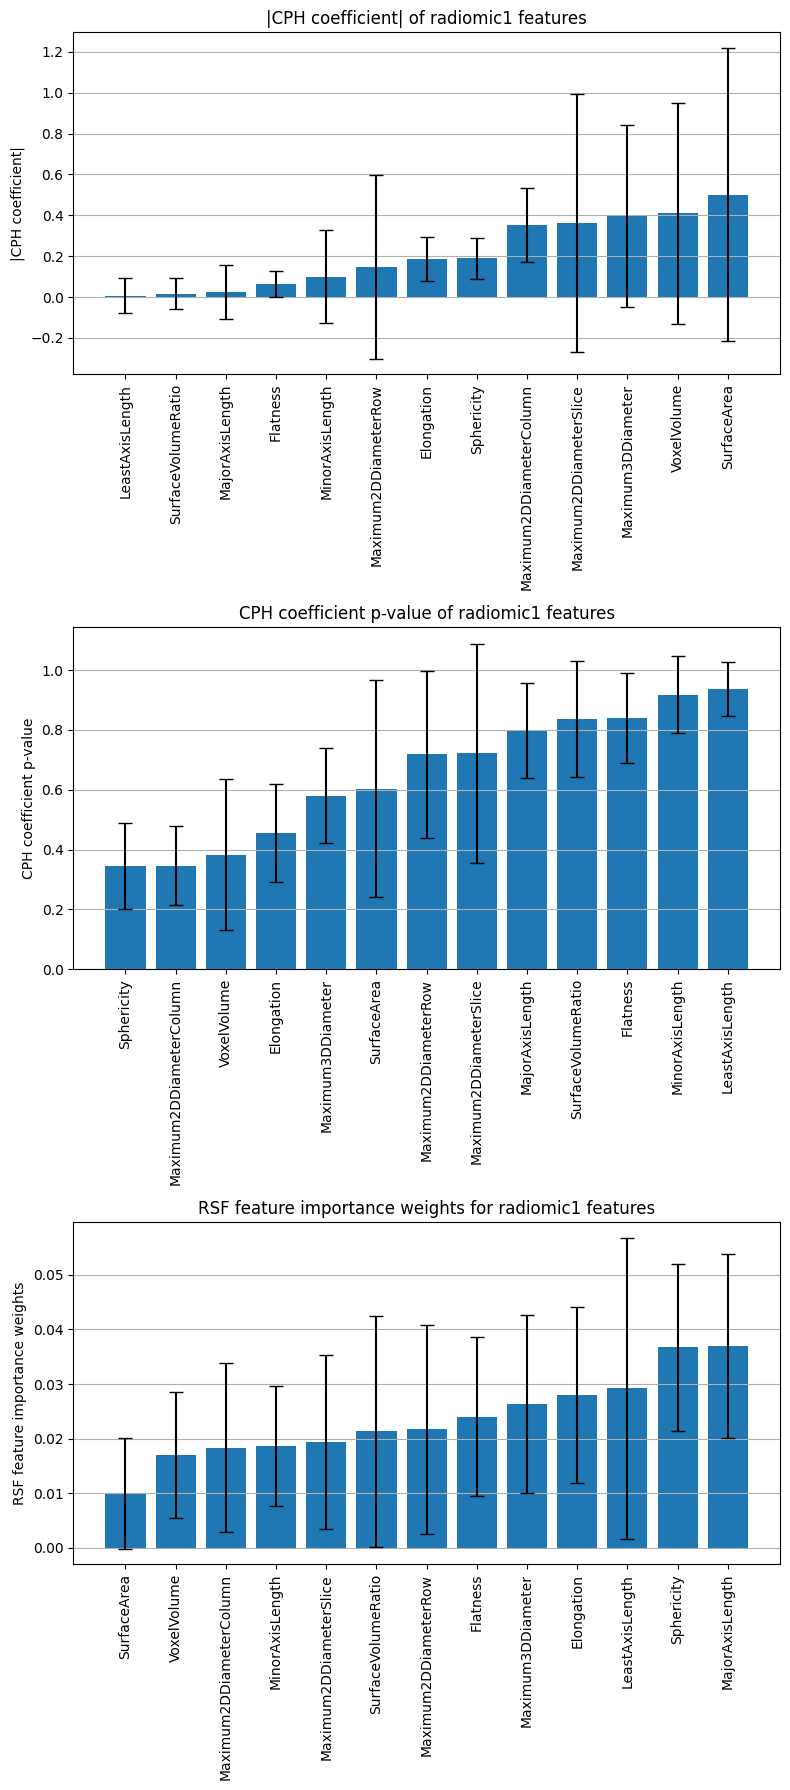

In [10]:
rad1_feature_names_cleaned = [name.replace('original_shape_', '') for name in radiomics1_feature_names]
fig, axes = plt.subplots(3, 1, figsize=(8,18))

plot_metrics(np.absolute(rad1_avg_coef), rad1_std_coef, rad1_feature_names_cleaned, '|CPH coefficient|','|CPH coefficient| of radiomic1 features', axes[0])
plot_metrics(rad1_avg_p, rad1_std_p, rad1_feature_names_cleaned, 'CPH coefficient p-value','CPH coefficient p-value of radiomic1 features', axes[1])
plot_metrics(rad1_avg_rsf_weight, rad1_std_rsf_weight, rad1_feature_names_cleaned, 'RSF feature importance weights','RSF feature importance weights for radiomic1 features', axes[2])

fig.tight_layout()

## Radiomics 2

In [11]:
radiomics2_feature_names = ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance']
radiomics2_feature_names.sort()

In [12]:
cph_file_name = "cph_radiomics2_all.html"
rsf_file_name = "rsf_radiomics2_all.html"

radiomics2_df, rad2_avg_coef, rad2_std_coef, rad2_avg_p, rad2_std_p, rad2_avg_rsf_weight, rad2_std_rsf_weight = k_fold_feature_importance_metrics(cph_file_name, rsf_file_name, radiomics2_feature_names)
display(radiomics2_df)

,Feature,CPH coefficient,CPH p-value,RSF Importance Weight
0,original_firstorder_10Percentile,-0.513 ± 0.691,0.606 ± 0.338,0.024 ± 0.013
1,original_firstorder_90Percentile,1.061 ± 1.235,0.376 ± 0.298,0.019 ± 0.021
2,original_firstorder_Energy,0.331 ± 0.291,0.224 ± 0.249,0.017 ± 0.005
3,original_firstorder_Entropy,-0.429 ± 0.522,0.672 ± 0.341,0.018 ± 0.011
4,original_firstorder_InterquartileRange,0.075 ± 0.093,0.806 ± 0.162,0.020 ± 0.006
5,original_firstorder_Kurtosis,-0.216 ± 0.193,0.577 ± 0.170,0.030 ± 0.014
6,original_firstorder_Maximum,0.007 ± 0.075,0.791 ± 0.134,0.046 ± 0.011
7,original_firstorder_Median,-0.077 ± 0.206,0.619 ± 0.175,0.031 ± 0.019
8,original_firstorder_Minimum,0.033 ± 0.040,0.806 ± 0.234,0.018 ± 0.012
9,original_firstorder_RootMeanSquared,0.095 ± 0.256,0.715 ± 0.191,0.007 ± 0.004


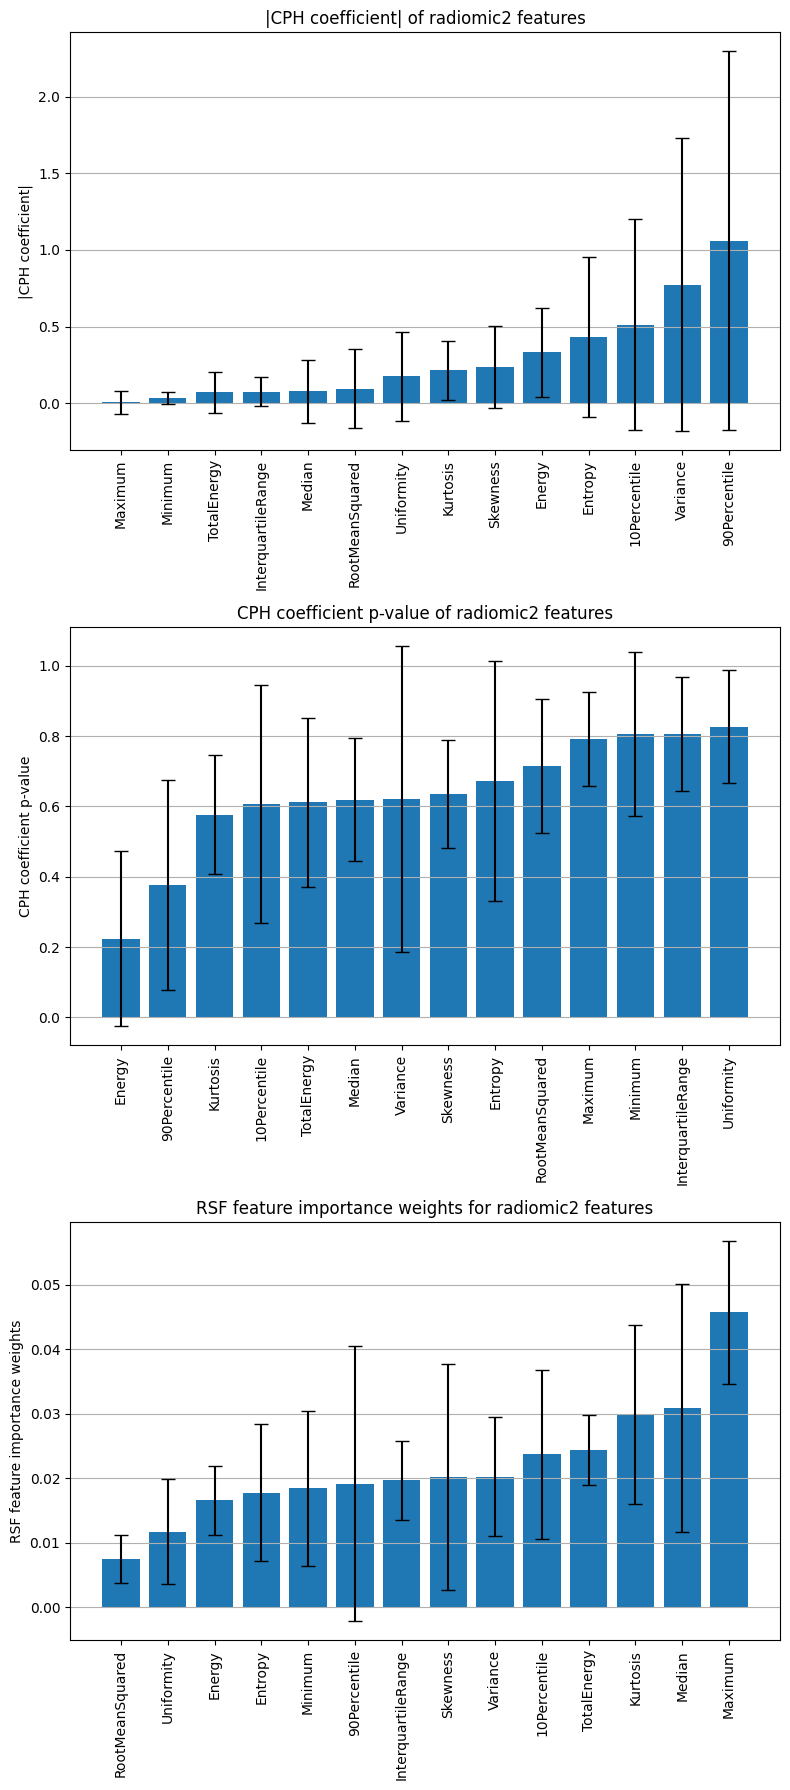

In [13]:
rad2_feature_names_cleaned = [name.replace('original_firstorder_', '') for name in radiomics2_feature_names]
fig, axes = plt.subplots(3, 1, figsize=(8,18))

plot_metrics(np.absolute(rad2_avg_coef), rad2_std_coef, rad2_feature_names_cleaned, '|CPH coefficient|','|CPH coefficient| of radiomic2 features', axes[0])
plot_metrics(rad2_avg_p, rad2_std_p, rad2_feature_names_cleaned, 'CPH coefficient p-value','CPH coefficient p-value of radiomic2 features', axes[1])
plot_metrics(rad2_avg_rsf_weight, rad2_std_rsf_weight, rad2_feature_names_cleaned, 'RSF feature importance weights','RSF feature importance weights for radiomic2 features', axes[2])

fig.tight_layout()

# Correlation Matrix

/Users/mollydasso/Code/survival_nlst/survival_nlst_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mollydasso/Code/survival_nlst/survival_nlst_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3258: DtypeWarning: Columns (201,224,225,328,330,331,332,333,334) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


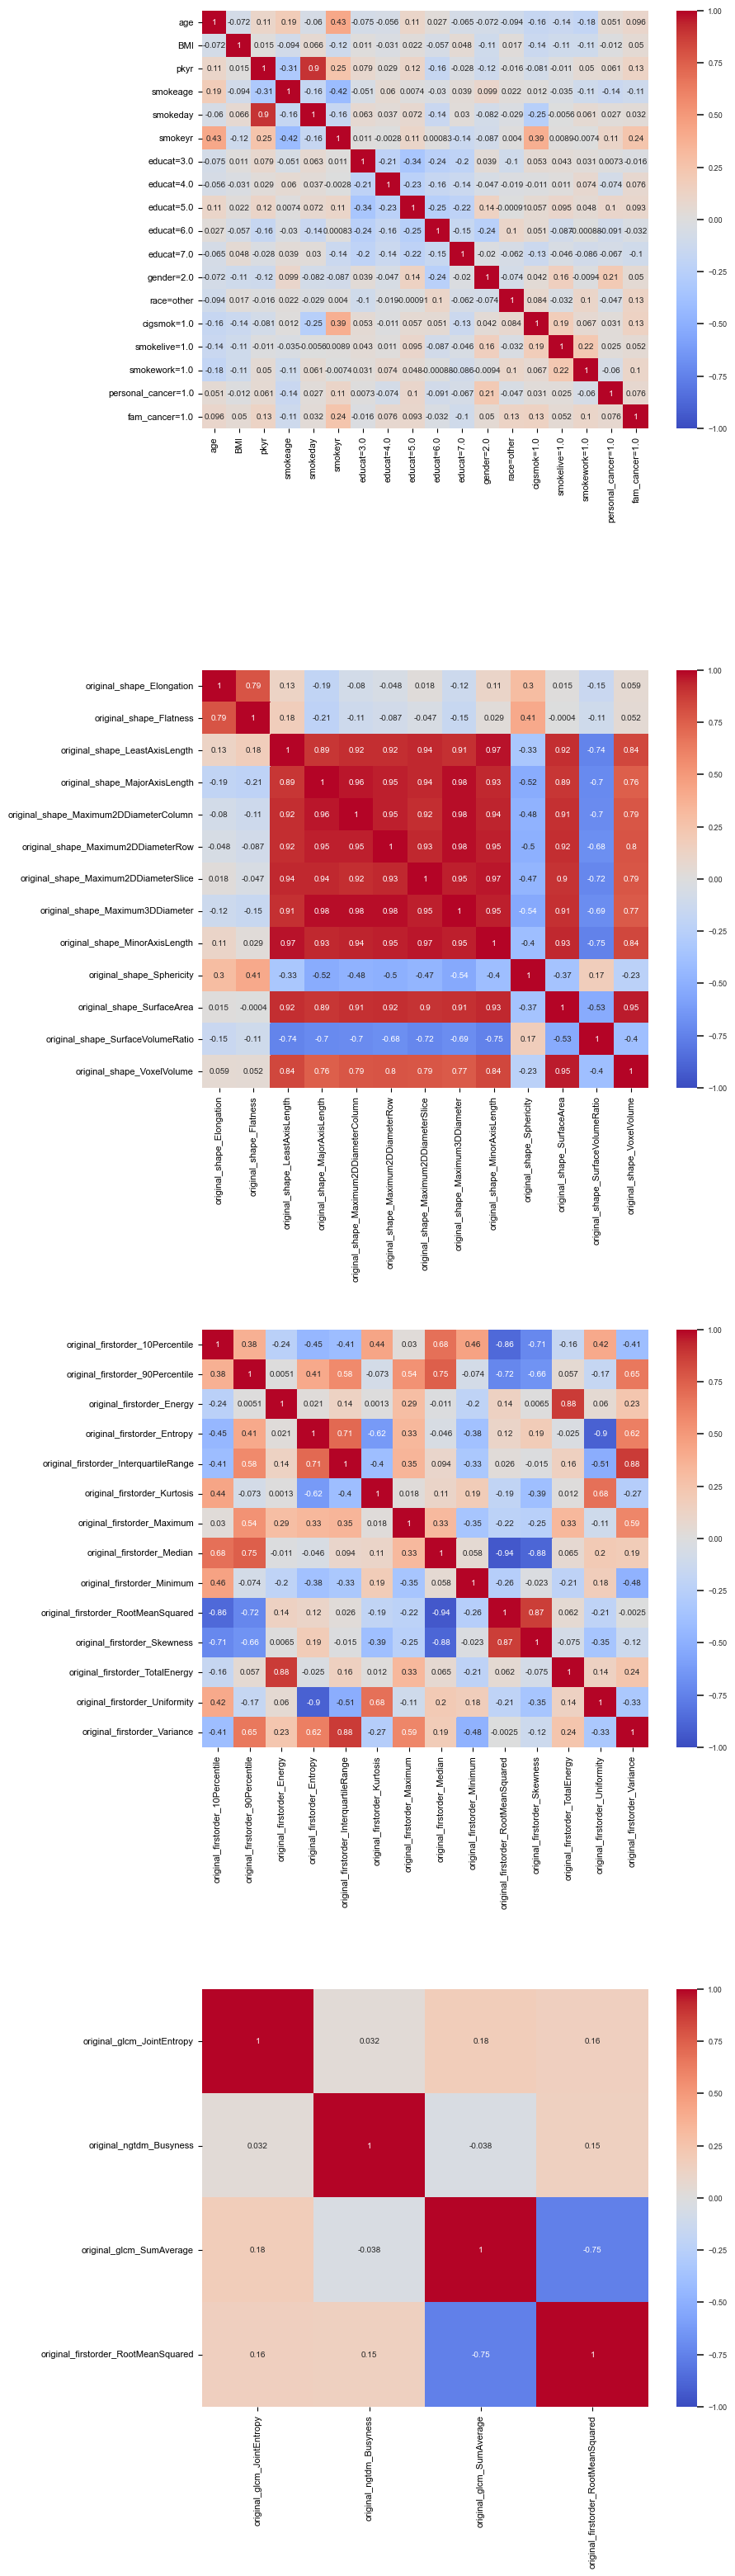

In [14]:
import seaborn as sn

from sklearn.model_selection import KFold
from glob import glob
from data_loader import get_pids_split
from results_utils import *

data_root = '../data/'
csv_path = '../data/'
file_list = glob('../data/pyradiomics_features/'+'/*')
radiomics_feature_name_file = '../data/'

train_pos, val_pos, test_pos, _, _, _ = get_pids_split(data_root+'pids.txt')
train_pids = train_pos + val_pos

fig, axes = plt.subplots(4, 1, figsize=(8,30))
fig.tight_layout(h_pad=10.0)

prsndf = pd.read_csv(csv_path+'nlst_15kpct_prsn_062119.csv')
prsndf = prsndf[prsndf['scr_group']== 1] # cancer positive

pids_radiomics = []
radiomics = []
for f in file_list:
    pids_radiomics.append(int(f.split('/')[-1].split('.')[0]))
    radiomics.append(np.load(f)['arr_0'])
radiomics = np.array(radiomics)
df_radiomics = pd.DataFrame(radiomics, columns=[str(i) for i in range(np.shape(radiomics)[1])], index=pids_radiomics)

prsndf = prsndf[prsndf['pid'].isin(pids_radiomics)]
prsndf_rad = prsndf.join(df_radiomics, on='pid')
raddf = prsndf_rad.iloc[:,-107:]
numericals = [str(i) for i in range (107)]

#########################################################
# Clinical
x_train, y_train, df_train = parse_clinical(train_pids, prsndf)

clin_corr_matrix = x_train.corr()
sn.set(font_scale=0.6)
axes[0].tick_params(axis='both', which='major', labelsize=8)
a = sn.heatmap(clin_corr_matrix, annot=True, ax=axes[0], vmin=-1, vmax=1, cmap='coolwarm')

#########################################################
rad_feature_names = []
with open(radiomics_feature_name_file
         + 'pyradiomics_features.txt') as f:
    for line in f.readlines():
        rad_feature_names.append(line.strip())

# Radiomics 1
x_train_rad, y_train, df_train = parse_radiomics(train_pids, prsndf_rad)

f1 = [str(i) for i in range (14)]
x_train_rad1 = x_train_rad[f1].copy()    
x_train_rad1 = x_train_rad1.drop(columns=['8']) 

f1 = [rad_feature_names[i] for i in range(14)]
f1.remove(rad_feature_names[8])

x_train_rad1.columns = f1
rad1_feature_names = f1 

rad1_corr_matrix = x_train_rad1.corr()
sn.set(font_scale=0.6)
axes[1].tick_params(axis='both', which='major', labelsize=8)
a = sn.heatmap(rad1_corr_matrix, annot=True, ax=axes[1], vmin=-1, vmax=1, cmap='coolwarm')

# Radiomics 2
f2 = [str(i) for i in range (14, 32)]
x_train_rad2 = x_train_rad[f2].copy()    
x_train_rad2 = x_train_rad2.drop(columns=['21', '22', '25', '26']) 

f2_indices = [14, 15, 16, 17, 18, 19, 20, 23, 24, 27, 28, 29, 30, 31]
f2 = [rad_feature_names[i] for i in f2_indices]

x_train_rad2.columns = f2
rad2_feature_names = f2 

rad2_corr_matrix = x_train_rad2.corr()
sn.set(font_scale=0.6)
axes[2].tick_params(axis='both', which='major', labelsize=8)
a = sn.heatmap(rad2_corr_matrix, annot=True, ax=axes[2], vmin=-1, vmax=1, cmap='coolwarm')

#Radiomics 3
f3 = ['50', '102', '53', '27']
x_train_rad3 = x_train_rad[f3].copy()

f3 = rad_feature_names.copy()
f3 = [rad_feature_names[i] for i in [50, 102, 53, 27]] #.remove(rad_feature_names[21])
x_train_rad3.columns = f3
rad3_feature_names = f3

rad3_corr_matrix = x_train_rad3.corr()
sn.set(font_scale=0.6)
axes[3].tick_params(axis='both', which='major', labelsize=8)
a = sn.heatmap(rad3_corr_matrix, annot=True, ax=axes[3], vmin=-1, vmax=1, cmap='coolwarm')

# Average C-index and MTD-AUC on Validation Set

In [15]:
c_index_by_fold = []
mtd_auc_by_fold = []
for i in range(5):
    result_file = outer_dir + "split" + str(i) + "/results.txt"
    results_df = pd.read_csv(result_file, sep='\t', header=None, names=["Experiment name", "C-index", "MTD-AUC"])
    
    c_index_by_fold.append(results_df["C-index"].to_numpy())
    mtd_auc_by_fold.append(results_df["MTD-AUC"].to_numpy())
    
c_index = np.stack(c_index_by_fold, axis=0)
avg_c_index = np.mean(c_index, axis=0)
std_c_index = np.std(c_index, axis=0)
str_c_index = ["{:.3f} ± {:.3f}".format(mean, std) for (mean, std) in zip(avg_c_index, std_c_index)]

mtd_auc = np.stack(mtd_auc_by_fold, axis=0)
avg_mtd_auc = np.mean(mtd_auc, axis=0)
std_mtd_auc = np.std(mtd_auc, axis=0)
str_mtd_auc = ["{:.3f} ± {:.3f}".format(mean, std) for (mean, std) in zip(avg_mtd_auc, std_mtd_auc)]

k_fold_results_df = pd.DataFrame(data={"Experiment name": results_df["Experiment name"].to_numpy(), "C-index": str_c_index, "MTD-AUC": str_mtd_auc})
k_fold_results_df[["Model", "Data", "Subset"]] = k_fold_results_df["Experiment name"].str.split("-", expand=True)
k_fold_results_df.drop(columns='Subset', inplace=True)
k_fold_results_df.replace("CPH_lifelines", "CPH", inplace=True)
display(k_fold_results_df)

,Experiment name,C-index,MTD-AUC,Model,Data
0,CPH_lifelines-clinical-all,51.760 ± 4.314,55.476 ± 4.137,CPH,clinical
1,RSF-clinical-all,54.514 ± 7.698,55.608 ± 9.592,RSF,clinical
2,CPH_lifelines-radiomics1-all,63.508 ± 9.246,67.828 ± 9.613,CPH,radiomics1
3,RSF-radiomics1-all,63.658 ± 8.647,71.952 ± 9.258,RSF,radiomics1
4,CPH_lifelines-radiomics2-all,66.788 ± 11.038,71.292 ± 10.640,CPH,radiomics2
5,RSF-radiomics2-all,59.468 ± 4.323,65.314 ± 5.572,RSF,radiomics2
6,CPH_lifelines-radiomics3-all,63.634 ± 10.234,69.770 ± 11.442,CPH,radiomics3
7,RSF-radiomics3-all,60.108 ± 3.764,66.146 ± 6.029,RSF,radiomics3


# TD-AUC Curve

In [16]:
cph_auc_file = "clinical_all_cpc_auc.npy"
rsf_auc_file = "clinical_all_rsf_auc.npy"
va_times_file = "clinical_all_va_times.npy"

cph_auc_by_split = []
rsf_auc_by_split = []
va_times_by_split = []

max_start = 0
min_end = np.inf
for i in range(4):
    cph_auc_by_split.append(np.load(outer_dir + "split" + str(i) + "/" + cph_auc_file))
    rsf_auc_by_split.append(np.load(outer_dir + "split" + str(i) + "/" + rsf_auc_file))
    va_times = np.load(outer_dir + "split" + str(i) + "/" + va_times_file)
    va_times_by_split.append(va_times)
    if va_times[0] > max_start: 
        max_start = va_times[0]
    if va_times[-1] < min_end:
        min_end = va_times[-1]

cph_auc_pruned = []
rsf_auc_pruned = []
for va_times, cph_auc, rsf_auc in zip(va_times_by_split, cph_auc_by_split, rsf_auc_by_split):
    start_idx = np.where(va_times == max_start)[0][0]
    end_idx = np.where(va_times == min_end)[0][0]
    cph_auc_pruned.append(cph_auc[start_idx:end_idx])
    rsf_auc_pruned.append(rsf_auc[start_idx:end_idx])
    
    
cph_auc_matrix = np.stack(cph_auc_pruned, axis=0)
cph_auc_mean = np.mean(cph_auc_matrix, axis=0)
cph_auc_std = np.std(cph_auc_matrix, axis=0)

rsf_auc_matrix = np.stack(rsf_auc_pruned, axis=0)
rsf_auc_mean = np.mean(rsf_auc_matrix, axis=0)
rsf_auc_std = np.std(rsf_auc_matrix, axis=0)

times = np.arange(max_start, min_end)

In [17]:
times = times[::30]
cph_auc_mean = cph_auc_mean[::30]
cph_auc_std = cph_auc_std[::30]
rsf_auc_mean = rsf_auc_mean[::30]
rsf_auc_std = rsf_auc_std[::30]

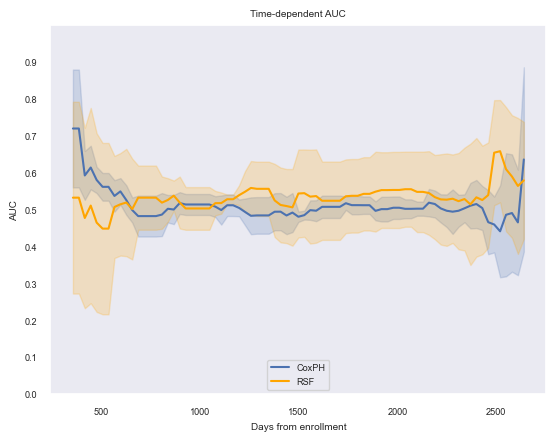

In [18]:
plt.ylim(0.0,1.0)
locs, labels = plt.yticks()  # Get the current locations and labels.
plt.yticks(np.arange(0.0, 1, step=0.1))  # Set label locations.
plt.plot(times, cph_auc_mean, "-", label="CoxPH", color="b")
plt.fill_between(times, cph_auc_mean - cph_auc_std, cph_auc_mean + cph_auc_std, color='b', alpha=0.2)
plt.plot(times, rsf_auc_mean, "-", label="RSF", color="orange")
plt.fill_between(times, rsf_auc_mean - rsf_auc_std, rsf_auc_mean + rsf_auc_std, color='orange', alpha=0.2)
plt.xlabel("Days from enrollment")
plt.ylabel("AUC")
plt.title("Time-dependent AUC")
plt.legend(loc="lower center")
plt.grid()